In [1]:
# imports
import numpy as np
from scipy.optimize import curve_fit

### Muon momentum resolution

Paper: https://arxiv.org/pdf/2212.07338

$\frac{\sigma(p_T)}{p_T} = \frac{r_0}{p_T} \oplus r_1 \oplus r_2 \cdot p_T$

which is equal to

$\frac{\sigma(p_T)}{p_T} = \sqrt{\left(\frac{r_0}{p_T} \right)^2 + r_1^2 + (r_2\cdot p_T)^2}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

etas = np.linspace(0, 2.5, 200)
pts  = np.logspace(0, 3.5, 200)
E, P = np.meshgrid(etas, pts)

scale = 10e-3
# ---------- OLD (past) resolution ----------
def past_res(pt, eta):
    return ((abs(eta) <= 0.5) * (pt > 0.1)* np.sqrt(0.01**2 + (pt*1.0e-4)**2)
          + ((abs(eta) > 0.5) & (abs(eta) <= 1.5)) * (pt > 0.1) * np.sqrt(0.015**2 + (pt*1.5e-4)**2)
          + ((abs(eta) > 1.5) & (abs(eta) <= 2.5)) * (pt > 0.1) * np.sqrt(0.025**2 + (pt*3.5e-4)**2))

# ---------- ID resolution ----------
def id_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt(0.0044**2 + (0.00012*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt(0.0067**2 + (0.00031*pt)**2) +
            (abs(eta) >= 2.0)  * np.sqrt(0.0094**2 + (0.00008*pt)**2))

# ---------- MS resolution ----------
def ms_res(pt, eta):
    return ((abs(eta) < 1.05) * np.sqrt((((71+63)/2)*scale/pt)**2 + (((13.5+17.2)/2)*scale)**2 + (((0.11+0.12)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((42+44)/2)*scale/pt)**2 + (((26.7+29.2)/2)*scale)**2 + (((0.14+0.18)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((61+47)/2)*scale/pt)**2 + (((16.8 + 17.8)/2)*scale)**2 + (((0.11+0.16)/2)*scale*pt)**2))

# ---------- CB resolution ----------
def cb_res(pt, eta):
    return ((abs(eta) <= 1.05) * np.sqrt((((6.7+6.5)/2)*scale)**2 + (((0.08 + 0.11)/2)*scale*pt)**2) +
            ((abs(eta) >= 1.05) & (abs(eta) < 2.0)) * np.sqrt((((10.3+8.9)/2)*scale)**2 + (((0.24 + 0.29)/2)*scale*pt)**2) +
            (abs(eta) >= 2.0) * np.sqrt((((10.6+11.5)/2)*scale)**2 + (((0.21 + 0.26)/2)*scale*pt)**2))

# ATLAS reference (ATL-PHYS-PUB-2013-009)
def atlas_ref(pt, eta):
    term_inner_A = pt*np.sqrt((0.24/pt)**2 + 0.02676**2 + (0.00012*pt)**2)
    term_outer_A = pt*np.sqrt(0.0388**2 + (0.00016*pt)**2)
    term_inner_C = np.sqrt(0.01607**2 + (0.000307*pt)**2)
    term_outer_B = np.sqrt(0.03**2 + (0.000387*pt)**2)
    term_inner_B = pt*np.sqrt(0.01061**2 + (0.000157*pt)**2)
    
    num = ( (abs(eta)<1.05)*term_inner_A*term_inner_C + (abs(eta)>=1.05)*term_outer_A ) * np.sqrt(0.03**2 + (0.000387*pt)**2)
    den = np.sqrt( ((abs(eta)<1.05)*term_inner_A + (abs(eta)>=1.05)*term_outer_A)**2 +
                   ((abs(eta)<1.05)*term_inner_B + (abs(eta)>=1.05)*pt*np.sqrt(0.03**2 + (0.000387*pt)**2))**2 )
    return num/den


# ---------- Compute fractional resolutions ----------
past_frac = past_res(P, E) / P
id_frac   = id_res(P, E) / P
ms_frac   = ms_res(P, E) / P
cb_frac   = cb_res(P, E) / P
atlas_frac = atlas_ref(P, E)/P

# ---------- Plot ----------
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
fig.suptitle("Muon momentun resolution σ(pT)/pT vs pT and η", fontsize=14)

def make_plot(ax, Z, title):
    im = ax.pcolormesh(E, P, Z, shading='auto', cmap='viridis', norm=LogNorm())  # <-- fixed
    ax.set_title(title)
    ax.set_xlabel("|η|")
    ax.set_ylabel("pT [GeV]")
    ax.set_yscale('log')
    plt.colorbar(im, ax=ax, label="σ(pT)/pT")
    return im

make_plot(axs[0,0], past_frac,  "Past Delphes (default)")
make_plot(axs[0,1], id_frac,    "Run 2 ID")
make_plot(axs[0,2], ms_frac,    "Run 2 MS")
make_plot(axs[1,0], cb_frac,    "Run 2 CB")
make_plot(axs[1,1], atlas_frac, "ATLAS Ref (2013-009)")
axs[1,2].axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

<Figure size 1400x800 with 11 Axes>

### Electron Momentum Resolution

Paper: https://cds.cern.ch/record/2203514/files/ATL-PHYS-PUB-2016-015.pdf

$\frac{\sigma(E)}{E} = \frac{a} {\sqrt{E}} \oplus \frac{b}{E} \oplus c$

In [3]:
a_data = np.genfromtxt("data/Electron Momentum Resolution - a.csv", delimiter=",", skip_header=1)
c_data = np.genfromtxt("data/Electron Momentum Resolution - c.csv", delimiter=",", skip_header=1)

a_vals, eta_vals = a_data.T
c_vals, eta1, eta2 = c_data.T

In [4]:
a_avg = []
for e1, e2 in zip(eta1, eta2):
    mask = (eta_vals >= e1) & (eta_vals < e2)
    if np.any(mask):
        a_avg.append(np.mean(a_vals[mask]))
    else:
        a_avg.append(np.interp((e1 + e2)/2, eta_vals, a_vals))
a_avg = np.array(a_avg)

lines = []
for i in range(len(c_vals)):
    e1, e2, a_i, c_i = eta1[i], eta2[i], a_avg[i], c_vals[i]
    lines.append(f"({e1:.2f} < eta) && (eta <= {e2:.2f}) * (pt > 0.1) * sqrt(({abs(a_i):.3f}/sqrt(pt))^2 + ({c_i:.8f})^2)")

delphes_block = "module MomentumSmearing ElectronMomentumSmearing {\n"
delphes_block += "  set InputArray ElectronTrackingEfficiency/electrons\n"
delphes_block += "  set OutputArray electrons\n\n"
delphes_block += "  # Energy-dependent resolution tuned from ATLAS Run-2 data\n"
delphes_block += "  # σ(pT)/pT = sqrt( (a(η)/sqrt(pT))^2 + c(η)^2 )\n\n"
delphes_block += "  set ResolutionFormula {\n"
delphes_block += " +\n".join(lines) + "\n  }\n}"
delphes_block

with open("test.txt", "w") as f:
    f.write(delphes_block)

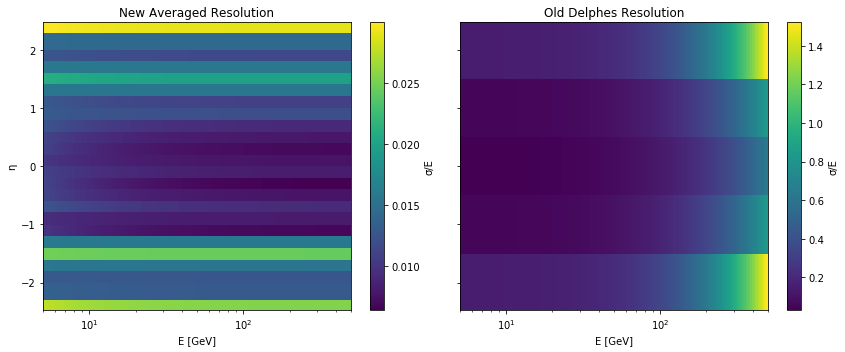

In [5]:
E_vals = np.logspace(np.log10(5), np.log10(500), 200)
eta_dense = np.linspace(-2.47, 2.47, 300)
E_grid, eta_grid = np.meshgrid(E_vals, eta_dense)

bin_edges = np.concatenate([eta1, [eta2[-1]]])
bin_idx = np.digitize(eta_grid, bin_edges) - 1
bin_idx = np.clip(bin_idx, 0, len(a_avg) - 1)

a_map = a_avg[bin_idx]
c_map = c_vals[bin_idx]

resolution_new_avg = np.sqrt((a_map / np.sqrt(E_grid))**2 + (c_map)**2)

def old_resolution(pt, eta):
    abs_eta = np.abs(eta)
    if abs_eta <= 0.5:
        return np.sqrt(0.03**2 + (pt * 1.3e-3)**2)
    elif abs_eta <= 1.5:
        return np.sqrt(0.05**2 + (pt * 1.7e-3)**2)
    else:
        return np.sqrt(0.15**2 + (pt * 3.1e-3)**2)

old_resolution_vec = np.vectorize(old_resolution)
resolution_old = old_resolution_vec(E_grid, eta_grid)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

pcm1 = axs[0].pcolormesh(E_grid, eta_grid, resolution_new_avg, shading='auto', cmap='viridis')
axs[0].set_xscale('log')
axs[0].set_title("New Averaged Resolution")
axs[0].set_xlabel("E [GeV]")
axs[0].set_ylabel("η")
fig.colorbar(pcm1, ax=axs[0], label="σ/E")

pcm2 = axs[1].pcolormesh(E_grid, eta_grid, resolution_old, shading='auto', cmap='viridis')
axs[1].set_xscale('log')
axs[1].set_title("Old Delphes Resolution")
axs[1].set_xlabel("E [GeV]")
fig.colorbar(pcm2, ax=axs[1], label="σ/E")

plt.tight_layout()
plt.show()


### Charged Hardron Momentum Resolution

### Charged Hadron Tracking Efficiency

Paper: https://arxiv.org/pdf/1704.07983

Figure 14.a



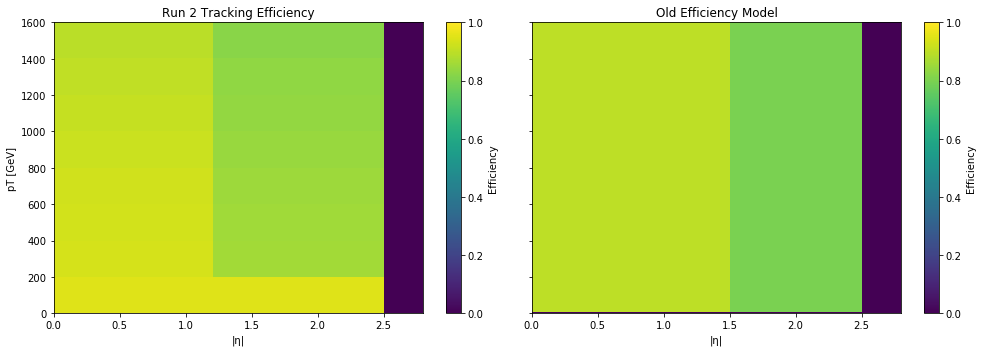

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define eta and pT grids
etas = np.linspace(0, 2.8, 200)
pts  = np.linspace(0, 1600, 200)
E, P = np.meshgrid(etas, pts)

# --- Original efficiency function ---
def tracking_eff(pt, eta):
    eff_barrel = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.93687 +
        ((pt >= 400) & (pt < 600))*0.93296 +
        ((pt >= 600) & (pt < 800))*0.92654 +
        ((pt >= 800) & (pt < 1000))*0.92011 +
        ((pt >= 1000) & (pt < 1200))*0.91257 +
        ((pt >= 1200) & (pt < 1400))*0.90531 +
        ((pt >= 1400) & (pt < 1600))*0.89721
    )
    eff_endcap = (
        (pt < 200)*0.95 +
        ((pt >= 200) & (pt < 400))*0.86145 +
        ((pt >= 400) & (pt < 600))*0.85838 +
        ((pt >= 600) & (pt < 800))*0.85251 +
        ((pt >= 800) & (pt < 1000))*0.84749 +
        ((pt >= 1000) & (pt < 1200))*0.83939 +
        ((pt >= 1200) & (pt < 1400))*0.83212 +
        ((pt >= 1400) & (pt < 1600))*0.82039
    )
    return (
        (np.abs(eta) <= 1.2)*eff_barrel +
        ((np.abs(eta) > 1.2) & (np.abs(eta) < 2.5))*eff_endcap +
        (np.abs(eta) >= 2.5)*0
    )

Z = tracking_eff(P, E)
# --- NEW efficiency function ---
def new_eff(pt, eta):
    return (
        (pt <= 0.5) * 0.00 +
        (np.abs(eta) <= 1.5) * (pt > 0.5) * (pt <= 5.0) * 0.85 +
        (np.abs(eta) <= 1.5) * (pt > 5.0) * 0.90 +
        (np.abs(eta) > 1.5) * (np.abs(eta) <= 2.5) * (pt > 0.5) * (pt <= 5.0) * 0.75 +
        (np.abs(eta) > 1.5) * (np.abs(eta) <= 2.5) * (pt > 5.0) * 0.80 +
        (np.abs(eta) > 2.5) * 0.00
    )

Z_new = new_eff(P, E)

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

im0 = axes[0].pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[0].set_title("Run 2 Tracking Efficiency")
axes[0].set_xlabel("|η|")
axes[0].set_ylabel("pT [GeV]")
fig.colorbar(im0, ax=axes[0], label="Efficiency")

im1 = axes[1].pcolormesh(E, P, Z_new, shading='auto', cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Old Efficiency Model")
axes[1].set_xlabel("|η|")
fig.colorbar(im1, ax=axes[1], label="Efficiency")

plt.tight_layout()
plt.show()


### Electron and Muon Tracking Efficiency

Paper: https://cds.cern.ch/record/2110140/files/ATL-PHYS-PUB-2015-051.pdf

<img src="images/tracking_eff_eta.png" style="width:300px;"><img src="images/tracking_eff_pt.png" style="width:300px;">


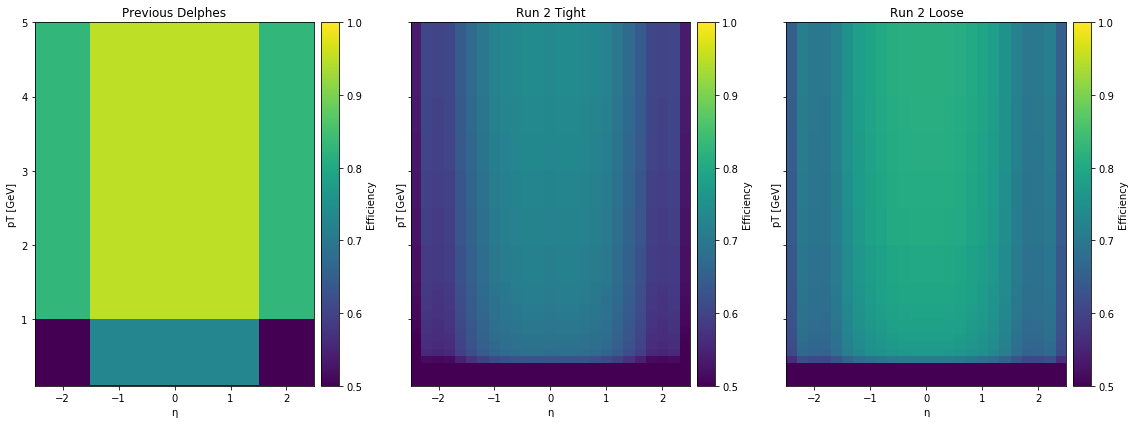

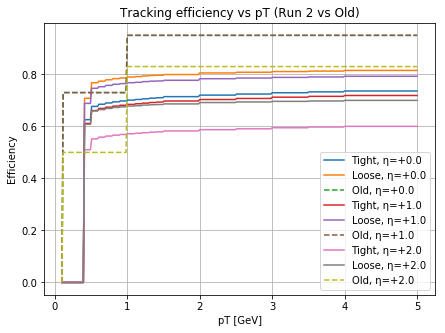

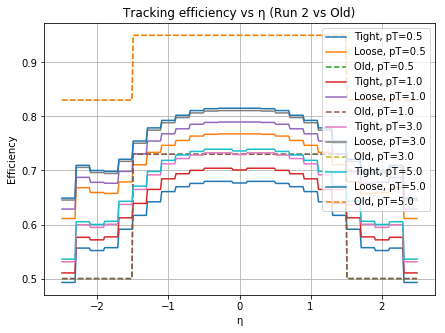

In [7]:
# eff_tight, eff_loose, pt/eta_1, pt/eta_2
track_pt = np.genfromtxt("data/Muon and Electron Tracking - pt.csv", delimiter=",", skip_header=1)
track_eta = np.genfromtxt("data/Muon and Electron Tracking - eta.csv", delimiter=",", skip_header=1)

# Columns: eff_tight, eff_loose, pt1, pt2
eff_tight_pt, eff_loose_pt, pt1, pt2 = track_pt.T
eff_tight_eta, eff_loose_eta, eta1, eta2 = track_eta.T

def eff_from_table(value, table):
    for eff, vmin, vmax in table:
        if vmin <= value < vmax:
            return eff
    if value >= table[-1][2]:
        return table[-1][0]
    return 0.0

def eff_new(pt, eta, quality="tight"):
    if quality == "tight":
        e_pt = eff_from_table(pt, list(zip(eff_tight_pt, pt1, pt2)))
        e_eta = eff_from_table(abs(eta), list(zip(eff_tight_eta, eta1, eta2)))
    else:
        e_pt = eff_from_table(pt, list(zip(eff_loose_pt, pt1, pt2)))
        e_eta = eff_from_table(abs(eta), list(zip(eff_loose_eta, eta1, eta2)))
    return e_pt * e_eta

def eff_old(pt, eta):
    if pt <= 0.1:
        return 0.0
    if abs(eta) <= 1.5:
        if pt <= 1.0: return 0.73
        elif pt <= 100: return 0.95
        else: return 0.99
    elif abs(eta) <= 2.5:
        if pt <= 1.0: return 0.50
        elif pt <= 100: return 0.83
        else: return 0.90
    else:
        return 0.0

etas = np.linspace(-2.5, 2.5, 300)
pts = np.linspace(0.1, 5.0, 300)
E, P = np.meshgrid(etas, pts)

v_new = np.vectorize(eff_new)
v_old = np.vectorize(eff_old)

Z_old = v_old(P, E)
Z_tight = v_new(P, E, "tight")
Z_loose = v_new(P, E, "loose")

fig, ax = plt.subplots(1, 3, figsize=(16,6), sharex=True, sharey=True)
for i, (Z, title) in enumerate(zip([Z_old, Z_tight, Z_loose],
                                  ["Previous Delphes", "Run 2 Tight", "Run 2 Loose"])):
    im = ax[i].pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0.5, vmax=1.0)
    ax[i].set_title(title)
    ax[i].set_xlabel("η")
    ax[i].set_ylabel("pT [GeV]")
    plt.colorbar(im, ax=ax[i], pad=0.02, label="Efficiency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
for eta in [0.0, 1.0, 2.0]:
    plt.plot(pts, v_new(pts, eta, "tight"), label=f"Tight, η={eta:+.1f}")
    plt.plot(pts, v_new(pts, eta, "loose"), label=f"Loose, η={eta:+.1f}")
    plt.plot(pts, v_old(pts, eta), '--', label=f"Old, η={eta:+.1f}")
plt.xlabel("pT [GeV]")
plt.ylabel("Efficiency")
plt.title("Tracking efficiency vs pT (Run 2 vs Old)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
for pt in [0.5, 1.0, 3.0, 5.0]:
    plt.plot(etas, v_new(pt, etas, "tight"), label=f"Tight, pT={pt:.1f}")
    plt.plot(etas, v_new(pt, etas, "loose"), label=f"Loose, pT={pt:.1f}")
    plt.plot(etas, v_old(pt, etas), '--', label=f"Old, pT={pt:.1f}")
plt.xlabel("η")
plt.ylabel("Efficiency")
plt.title("Tracking efficiency vs η (Run 2 vs Old)")
plt.grid(True)
plt.legend()
plt.show()

### Muon Efficiency

Paper: https://cds.cern.ch/record/2746302/files/Aad2021_Article_MuonReconstructionAndIdentific.pdf

<img src="images/eff_muon.png" style="width:800px;">

In [8]:
# x is the eta values while y is the efficiency (for pt > 15 GeV)
mu_eff_eta_tight = np.genfromtxt("data/Muon Eff - tight_eta.csv", delimiter=",", skip_header = 1)
mu_eff_eta_medium = np.genfromtxt("data/Muon Eff - medium_eta.csv", delimiter=",", skip_header = 1)
mu_eff_eta_loose = np.genfromtxt("data/Muon Eff - loose_eta.csv", delimiter=",", skip_header = 1)
# x is the pt values while y is the efficiency (for |eta| < 2.47)
mu_eff_pt_tight = np.genfromtxt("data/Muon Eff - tight_pt.csv", delimiter=",", skip_header = 1)
mu_eff_pt_medium = np.genfromtxt("data/Muon Eff - medium_pt.csv", delimiter=",", skip_header = 1)
mu_eff_pt_loose = np.genfromtxt("data/Muon Eff - loose_pt.csv", delimiter=",", skip_header = 1)

mu_eff_eta = [mu_eff_eta_tight, mu_eff_eta_medium, mu_eff_eta_loose]
mu_eff_pt = [mu_eff_pt_tight, mu_eff_pt_medium, mu_eff_pt_loose]

mu_eff_info = {}
quality = ["tight", "medium", "loose"]
for qual in quality:
    mu_eff_info[qual] = {
        "pt": [],
        "eta": [] 
    }
for c, qual in enumerate(quality):
    for i in range(len(mu_eff_eta_loose)):
        if i%2 == 0:
            eff = round(mu_eff_eta[c][i][1], 3)
            eta1 = round(mu_eff_eta[c][i][0], 3)
            eta2 = round(mu_eff_eta[c][i+1][0], 3)
            
            mu_eff_info[qual]["eta"].append((eff, (eta1, eta2)))
            

    for i in range(len(mu_eff_pt_loose)):
        if i%2 == 0:
            eff = round(mu_eff_pt[c][i][1], 3)
            pt1 = round(mu_eff_pt[c][i][0], 3)
            pt2 = round(mu_eff_pt[c][i+1][0], 3)

            mu_eff_info[qual]["pt"].append((eff, (pt1, pt2)))


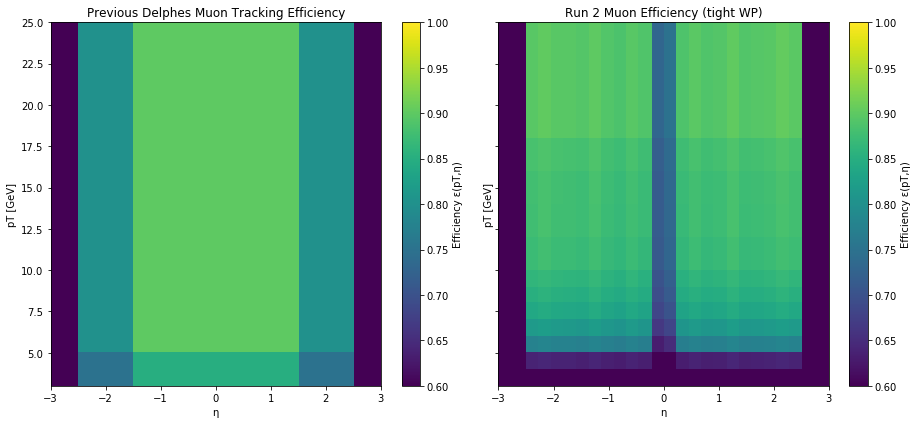

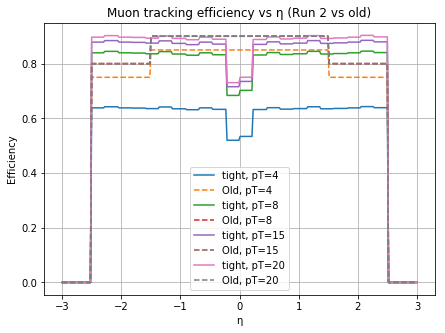

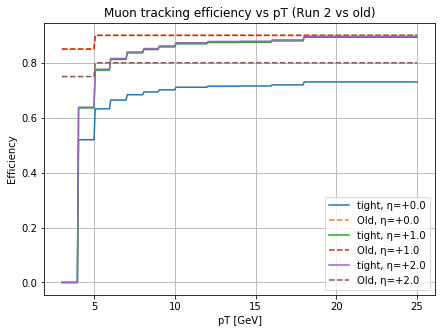

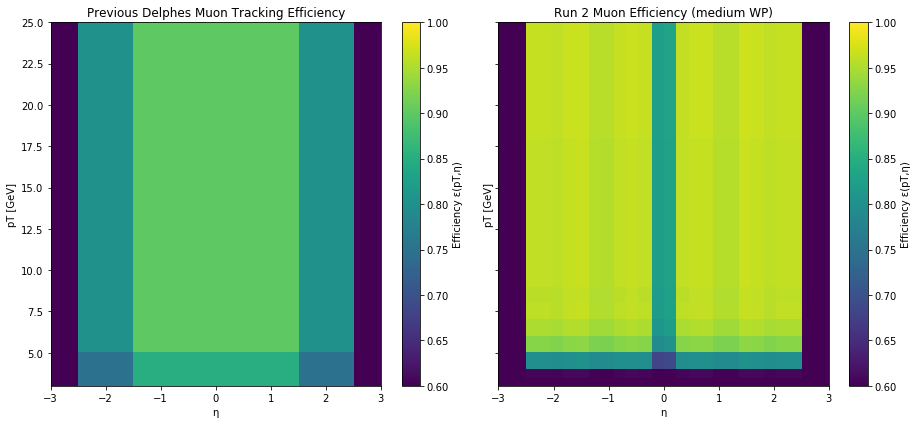

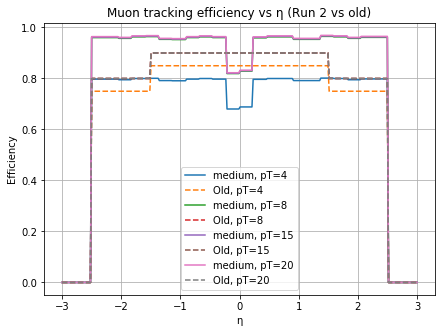

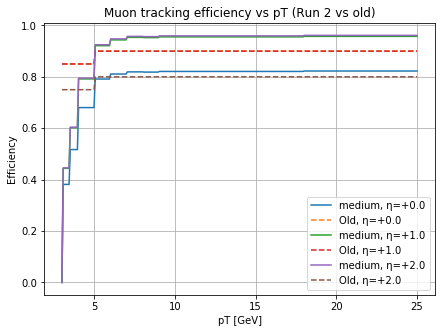

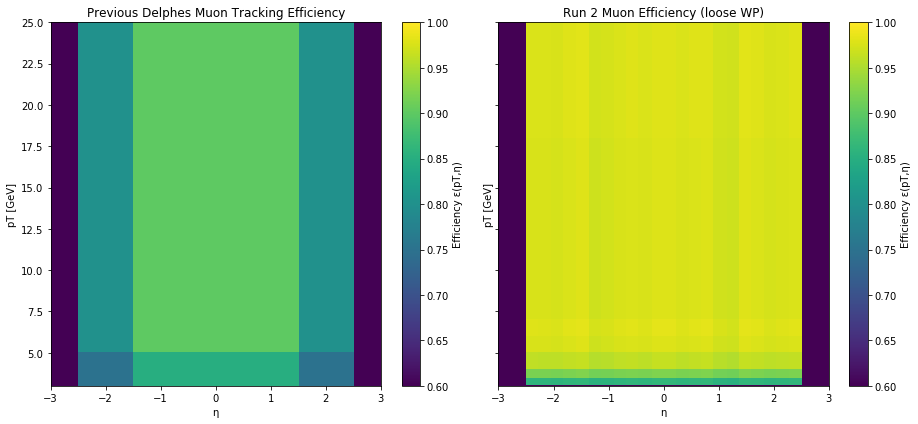

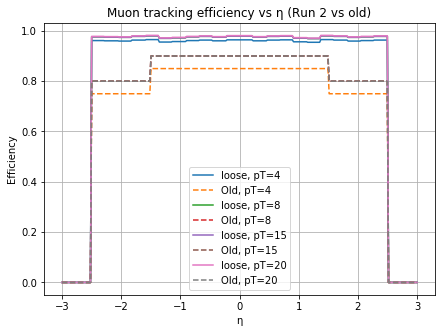

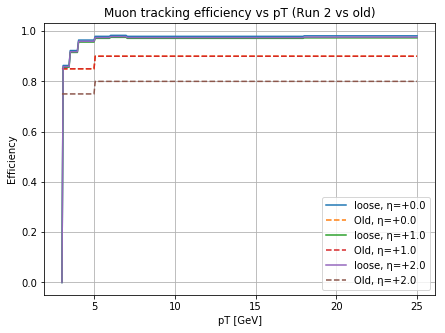

In [9]:

def eff_from_dict(info, var, value):
    for eff, (vmin, vmax) in info[var]:
        if vmin <= value < vmax:
            return eff
    if var == "pt" and value >= info[var][-1][1][1]:
        return info[var][-1][0]
    return 0.0

def run2_eff(pt, eta, wp="tight"):
    d = mu_eff_info[wp]
    e_pt = eff_from_dict(d, "pt", pt)
    e_eta = eff_from_dict(d, "eta", eta)
    return e_pt * e_eta

def old_eff(pt, eta):
    if pt <= 0.5:
        return 0.0
    elif abs(eta) <= 1.5:
        if pt <= 5.0:
            return 0.85
        else:
            return 0.90
    elif abs(eta) <= 2.5:
        if pt <= 5.0:
            return 0.75
        else:
            return 0.80
    else:
        return 0.0

# === Build grid ===
etas = np.linspace(-3, 3, 300)
pts = np.linspace(3, 25, 300)
E, P = np.meshgrid(etas, pts)
v_old = np.vectorize(old_eff)
v_run2 = np.vectorize(run2_eff)


for qual in quality:

    Z_tight = v_run2(P, E, qual)
    Z_old = v_old(P, E)

    fig, ax = plt.subplots(1, 2, figsize=(13,6), sharex=True, sharey=True)
    im0 = ax[0].pcolormesh(E, P, Z_old, shading='auto', cmap='viridis', vmin=0.6, vmax=1.0)
    im1 = ax[1].pcolormesh(E, P, Z_tight, shading='auto', cmap='viridis', vmin=0.6, vmax=1.0)
    plt.colorbar(im0, ax=ax[0], label='Efficiency ε(pT,η)')
    plt.colorbar(im1, ax=ax[1], label='Efficiency ε(pT,η)')
    ax[0].set_title('Previous Delphes Muon Tracking Efficiency')
    ax[1].set_title(f'Run 2 Muon Efficiency ({qual} WP)')
    for a in ax:
        a.set_xlabel('η')
        a.set_ylabel('pT [GeV]')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(7,5))
    for pt in [4, 8, 15, 20]:
        plt.plot(etas, v_run2(pt, etas, qual), label=f"{qual}, pT={pt:.0f}")
        plt.plot(etas, v_old(pt, etas), '--', label=f"Old, pT={pt:.0f}")
    plt.xlabel('η')
    plt.ylabel('Efficiency')
    plt.title('Muon tracking efficiency vs η (Run 2 vs old)')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,5))
    for eta in [0.0, 1.0, 2.0]:
        plt.plot(pts, v_run2(pts, eta, qual), label=f"{qual}, η={eta:+.1f}")
        plt.plot(pts, v_old(pts, eta), '--', label=f"Old, η={eta:+.1f}")
    plt.xlabel('pT [GeV]')
    plt.ylabel('Efficiency')
    plt.title('Muon tracking efficiency vs pT (Run 2 vs old)')
    plt.grid(True)
    plt.legend()
    plt.show()


### Electron Efficiency
Paper: https://arxiv.org/pdf/2308.13362

<img src="images/eff_electron_eta.png" style="width:300px;"><img src="images/eff_electron_pt.png" style="width:300px;">

In [10]:
e_eff_pt = np.genfromtxt("data/Electron Efficiency - pt.csv", delimiter=",", skip_header=1)
e_eff_eta = np.genfromtxt("data/Electron Efficiency - eta.csv", delimiter=",", skip_header=1)

eff_loose_pt, eff_medium_pt, eff_tight_pt, pt1, pt2 = e_eff_pt.T
eff_loose_eta, eff_medium_eta, eff_tight_eta, eta1, eta2 = e_eff_eta.T


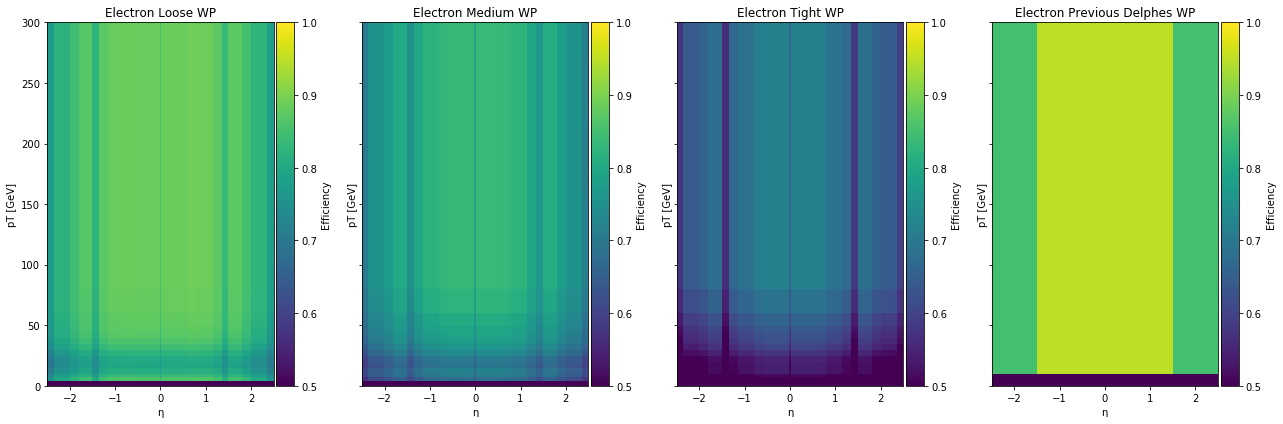

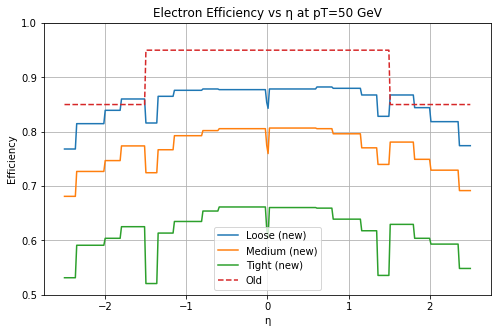

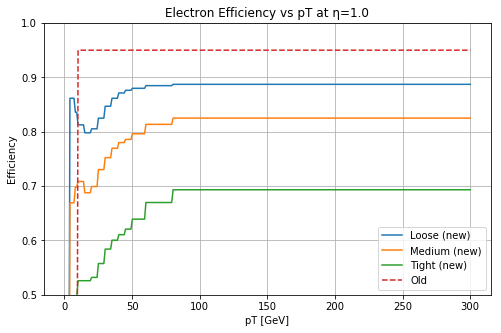

In [11]:

def eff_from_table(value, table):
    """Return efficiency corresponding to a value within a (eff, vmin, vmax) table."""
    for eff, vmin, vmax in table:
        if vmin <= value < vmax:
            return eff
    if value >= table[-1][2]:
        return table[-1][0]
    return 0.0

def eff_new(pt, eta, wp="loose"):
    if wp == "loose":
        e_pt = eff_from_table(pt, list(zip(eff_loose_pt, pt1, pt2)))
        e_eta = eff_from_table(eta, list(zip(eff_loose_eta, eta1, eta2)))
    elif wp == "medium":
        e_pt = eff_from_table(pt, list(zip(eff_medium_pt, pt1, pt2)))
        e_eta = eff_from_table(eta, list(zip(eff_medium_eta, eta1, eta2)))
    else:
        e_pt = eff_from_table(pt, list(zip(eff_tight_pt, pt1, pt2)))
        e_eta = eff_from_table(eta, list(zip(eff_tight_eta, eta1, eta2)))
    
    if pt < 4.0 and abs(eta) < 2.47:
        return 0.0

    return e_pt * e_eta
def eff_old(pt, eta):
    if pt <= 10.0:
        return 0.0
    if abs(eta) <= 1.5:
        return 0.95
    elif abs(eta) <= 2.5:
        return 0.85
    else:
        return 0.0

etas = np.linspace(-2.5, 2.5, 300)
pts = np.linspace(0, 300, 300)
E, P = np.meshgrid(etas, pts)

v_new = np.vectorize(eff_new)
v_old = np.vectorize(eff_old)

wps = ["loose", "medium", "tight"]
Zs = [v_new(P, E, wp) for wp in wps]
Z_old = v_old(P, E)

fig, ax = plt.subplots(1, 4, figsize=(18,6), sharex=True, sharey=True)
for i, (Z, title) in enumerate(zip(Zs + [Z_old],
                                  ["Loose", "Medium", "Tight", "Previous Delphes"])):
    im = ax[i].pcolormesh(E, P, Z, shading='auto', cmap='viridis', vmin=0.5, vmax=1.0)
    ax[i].set_title(f"Electron {title} WP")
    ax[i].set_xlabel("η")
    ax[i].set_ylabel("pT [GeV]")
    plt.colorbar(im, ax=ax[i], pad=0.01, label="Efficiency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for wp in wps:
    plt.plot(etas, v_new(50, etas, wp), label=f"{wp.capitalize()} (new)")
plt.plot(etas, v_old(50, etas), "--", label="Old")
plt.xlabel("η")
plt.ylabel("Efficiency")
plt.title("Electron Efficiency vs η at pT=50 GeV")
plt.legend()
plt.grid(True)
plt.ylim(0.5, 1.0)
plt.show()

plt.figure(figsize=(8,5))
for wp in wps:
    plt.plot(pts, v_new(pts, 1.0, wp), label=f"{wp.capitalize()} (new)")
plt.plot(pts, v_old(pts, 1.0), "--", label="Old")
plt.xlabel("pT [GeV]")
plt.ylabel("Efficiency")
plt.title("Electron Efficiency vs pT at η=1.0")
plt.legend()
plt.grid(True)
plt.ylim(0.5, 1.0)
plt.show()

### Photon Efficiency

Paper: https://arxiv.org/pdf/2308.13362

<img src="images/photon_eff_1.png" style="width:250px;"><img src="images/photon_eff_2.png" style="width:250px;"><img src="images/photon_eff_3.png" style="width:250px;"><img src="images/photon_eff_4.png" style="width:250px;">

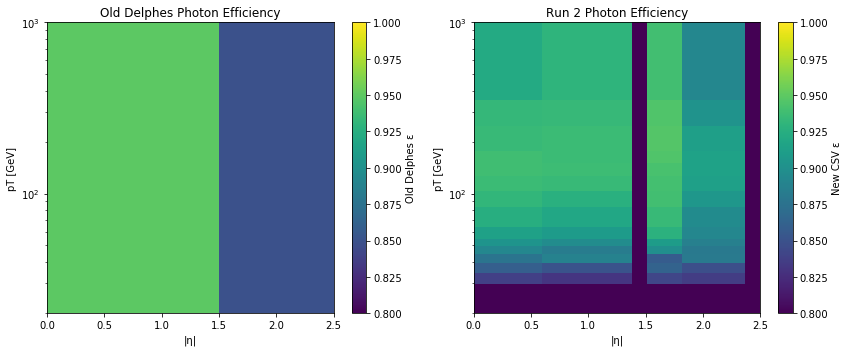

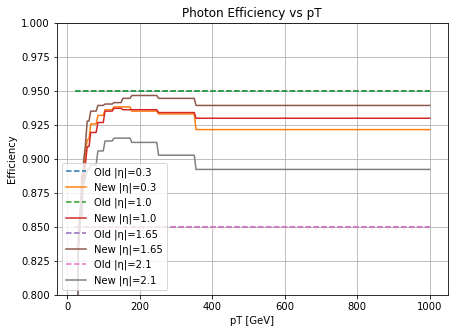

In [16]:
# --- Old Delphes photon efficiency ---
def old_photon_eff(pt, eta):
    aeta = abs(eta)
    if pt <= 10.0:
        return 0.0
    elif aeta <= 1.5:
        return 0.95
    elif 1.5 < aeta <= 2.5:
        return 0.85
    else:
        return 0.0

# --- New CSV-based photon efficiency ---
photon_eff_data = np.genfromtxt("data/Photon Efficiency - pt_eta.csv", delimiter=",", skip_header=1)
eff_0_eta_0_6, eff_0_6_eta_1_37, eff_1_52_eta_1_81, eff_1_81_eta_1_2_37, pt1, pt2 = photon_eff_data.T

eta_bins = [(0.0, 0.6), (0.6, 1.37), (1.52, 1.81), (1.81, 2.37)]
eff_eta = [eff_0_eta_0_6, eff_0_6_eta_1_37, eff_1_52_eta_1_81, eff_1_81_eta_1_2_37]

def new_photon_eff(pt, eta):
    aeta = abs(eta)
    for i, (emin, emax) in enumerate(eta_bins):
        if emin <= aeta < emax:
            eff_table = list(zip(eff_eta[i], pt1, pt2))
            for eff, pmin, pmax in eff_table:
                if pmin <= pt < pmax:
                    return eff
            if pt >= pt2[-1]:
                return eff_table[-1][0]
            return 0.0
    return 0.0

# --- Vectorize functions for plotting ---
v_old_eff = np.vectorize(old_photon_eff)
v_new_eff = np.vectorize(new_photon_eff)

# --- Create a meshgrid for pT and eta ---
etas = np.linspace(0, 2.5, 200)
pts = np.linspace(20, 1000, 200)
E, P = np.meshgrid(etas, pts)

# --- Compute efficiencies ---
Z_old = v_old_eff(P, E)
Z_new = v_new_eff(P, E)

# --- Plot comparison map ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pcolormesh(E, P, Z_old, shading='auto', cmap='viridis', vmin=0.8, vmax=1.0)
plt.colorbar(label="Old Delphes ε")
plt.xlabel("|η|")
plt.ylabel("pT [GeV]")
plt.title("Old Delphes Photon Efficiency")
plt.yscale('log')

plt.subplot(1,2,2)
plt.pcolormesh(E, P, Z_new, shading='auto', cmap='viridis', vmin=0.8, vmax=1.0)
plt.colorbar(label="New CSV ε")
plt.xlabel("|η|")
plt.ylabel("pT [GeV]")
plt.title("Run 2 Photon Efficiency")
plt.yscale('log')

plt.tight_layout()
plt.show()

# --- Optional: efficiency vs pT for fixed eta ---
plt.figure(figsize=(7,5))
for eta_fixed in [0.3, 1.0, 1.65, 2.1]:
    plt.plot(pts, v_old_eff(pts, eta_fixed), '--', label=f"Old |η|={eta_fixed}")
    plt.plot(pts, v_new_eff(pts, eta_fixed), '-', label=f"New |η|={eta_fixed}")
plt.xlabel("pT [GeV]")
plt.ylabel("Efficiency")
plt.title("Photon Efficiency vs pT")
plt.grid(True)
plt.legend()
plt.ylim(0.8, 1.0)
plt.show()

### B-tagging efficiencies

Paper: https://arxiv.org/abs/2211.16345

<img src="images/btag.png" style="width:250px;"><img src="images/ctag.png" style="width:250px;"><img src="images/light_tag.png" style="width:250px;">

In [13]:
b_tag_data = np.genfromtxt("data/b-tagging eff - b.csv", delimiter=",", skip_header=1)
c_tag_data = np.genfromtxt("data/b-tagging eff - c.csv", delimiter=",", skip_header=1)
light_tag_data = np.genfromtxt("data/b-tagging eff - light.csv", delimiter=",", skip_header=1)

eff_85_b, eff_77_b, eff_70_b, eff_60_b, pt_b = b_tag_data.T
eff_85_c, eff_77_c, eff_70_c, eff_60_c, pt_c = c_tag_data.T
eff_85_l, eff_77_l, eff_70_l, eff_60_l, pt_l = light_tag_data.T


/tmp/ipykernel_39490/1968388376.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_c, _ = curve_fit(fit_func_c, pt_c, eff_c, p0=[0.2, 0.02, 0.0034], maxfev=10000)
/tmp/ipykernel_39490/1968388376.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_c, _ = curve_fit(fit_func_c, pt_c, eff_c, p0=[0.2, 0.02, 0.0034], maxfev=10000)


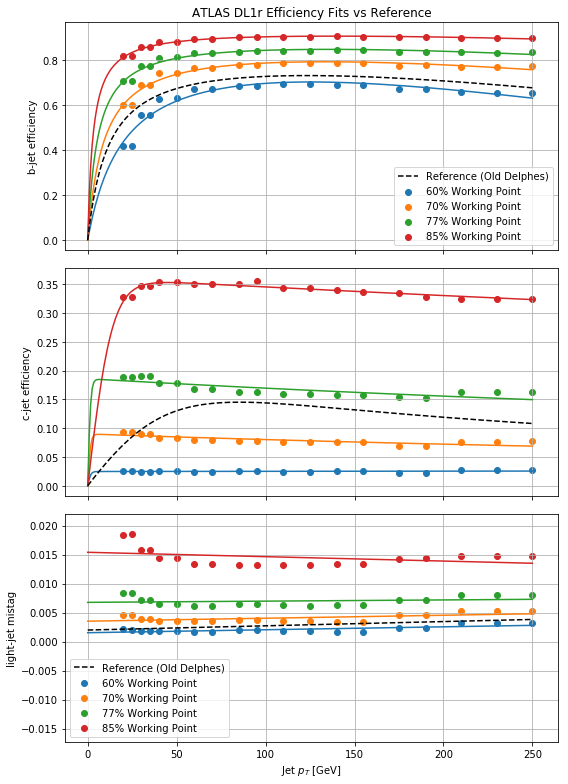


Working Point 60%:
  b-jets: A=0.383, B=0.00381, C=0.04990
  c-jets: A=0.025, B=0.59648, C=-0.00012
  light-jets: a=0.00154, b=0.0000051

Working Point 70%:
  b-jets: A=1.364, B=0.00237, C=0.11063
  c-jets: A=0.090, B=0.61605, C=0.00124
  light-jets: a=0.00352, b=0.0000051

Working Point 77%:
  b-jets: A=2.993, B=0.00181, C=0.18066
  c-jets: A=0.186, B=0.60700, C=0.00097
  light-jets: a=0.00677, b=0.0000021

Working Point 85%:
  b-jets: A=7.932, B=0.00129, C=0.32831
  c-jets: A=0.362, B=0.07200, C=0.00047
  light-jets: a=0.01540, b=-0.0000076


In [20]:
def eff_light_ref(pt):
    return 0.002 + 7.3e-06 * pt

def eff_c_ref(pt):
    return 0.20 * np.tanh(0.02 * pt) * (1 / (1 + 0.0034 * pt))

def eff_b_ref(pt):
    return 0.80 * np.tanh(0.003 * pt) * (30 / (1 + 0.086 * pt))

def fit_func_b(pt, A, B, C):
    """b-jet efficiency: A * tanh(B*pt) * (30 / (1 + C*pt))"""
    return A * np.tanh(B * pt) * (30 / (1 + C * pt))

def fit_func_c(pt, A, B, C):
    """c-jet efficiency: A * tanh(B*pt) * (1 / (1 + C*pt))"""
    return A * np.tanh(B * pt) * (1 / (1 + C * pt))

def fit_func_light(pt, a, b):
    """linear fit for light jets"""
    return a + b * pt

wps = {
    "60%": (eff_60_b, eff_60_c, eff_60_l, "C0"),
    "70%": (eff_70_b, eff_70_c, eff_70_l, "C1"),
    "77%": (eff_77_b, eff_77_c, eff_77_l, "C2"),
    "85%": (eff_85_b, eff_85_c, eff_85_l, "C3"),
}

pt_smooth = np.linspace(0, max(pt_b.max(), pt_c.max(), pt_l.max()), 300)

fig, axs = plt.subplots(3, 1, figsize=(8, 11), sharex=True)
axs[0].set_title("ATLAS DL1r Efficiency Fits vs Reference")

fit_results = {}

for wp, (eff_b, eff_c, eff_l, color) in wps.items():
    popt_b, _ = curve_fit(fit_func_b, pt_b, eff_b, p0=[0.8, 0.003, 0.086], maxfev=10000)
    popt_c, _ = curve_fit(fit_func_c, pt_c, eff_c, p0=[0.2, 0.02, 0.0034], maxfev=10000)
    popt_l, _ = curve_fit(fit_func_light, pt_l, eff_l, p0=[0.002, 7e-6], maxfev=10000)

    fit_results[wp] = {"b": popt_b, "c": popt_c, "l": popt_l}

    axs[0].scatter(pt_b, eff_b, color=color, label=f"{wp} Working Point")
    axs[0].plot(pt_smooth, fit_func_b(pt_smooth, *popt_b), color=color, linestyle="-")

    axs[1].scatter(pt_c, eff_c, color=color, label=f"{wp} Working Point")
    axs[1].plot(pt_smooth, fit_func_c(pt_smooth, *popt_c), color=color, linestyle="-")

    axs[2].scatter(pt_l, eff_l, color=color, label=f"{wp} Working Point")
    axs[2].plot(pt_smooth, fit_func_light(pt_smooth, *popt_l), color=color, linestyle="-")

axs[0].plot(pt_smooth, eff_b_ref(pt_smooth), "k--", label="Reference (Old Delphes)")
axs[1].plot(pt_smooth, eff_c_ref(pt_smooth), "k--", label="Reference (Old Delphes)")
axs[2].plot(pt_smooth, eff_light_ref(pt_smooth), "k--", label="Reference (Old Delphes)")

axs[0].set_ylabel("b-jet efficiency")
axs[1].set_ylabel("c-jet efficiency")
axs[2].set_ylabel("light-jet mistag")
axs[2].set_xlabel("Jet $p_T$ [GeV]")
for i, ax in enumerate(axs): 
    ax.grid(True) 
    if i == 1:
        continue
    ax.legend()

plt.tight_layout()
plt.show()

for wp, pars in fit_results.items():
    Ab, Bb, Cb = pars["b"]
    Ac, Bc, Cc = pars["c"]
    aL, bL = pars["l"]
    print(f"\nWorking Point {wp}:")
    print(f"  b-jets: A={Ab:.3f}, B={Bb:.5f}, C={Cb:.5f}")
    print(f"  c-jets: A={Ac:.3f}, B={Bc:.5f}, C={Cc:.5f}")
    print(f"  light-jets: a={aL:.5f}, b={bL:.7f}")